<a href="https://colab.research.google.com/github/vbwjsrh/example-C-/blob/main/DBSCAN_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**라이브러리 설치**




In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


>**구글 드라이브 연결**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


>**파일 저장하기**

In [3]:
file_path = '/content/drive/My Drive/Mall_Customers.xlsx'
mall_data = pd.read_excel(file_path)
print(mall_data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


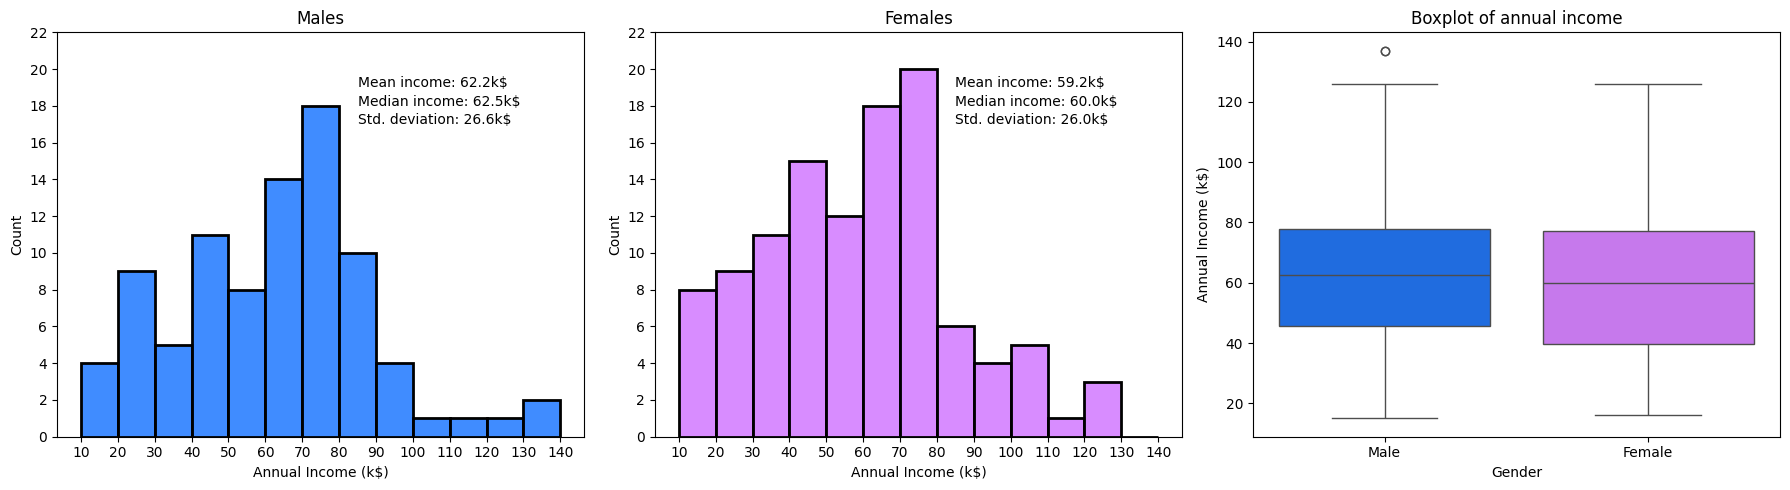

In [110]:
# 데이터 준비 (mall_data는 가정된 데이터프레임)
males_income = mall_data[mall_data['Gender'] == 'Male']['Annual Income (k$)']
females_income = mall_data[mall_data['Gender'] == 'Female']['Annual Income (k$)']

my_bins = range(10, 150, 10)

# 히스토그램 및 박스플롯 그리기
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 남성 히스토그램
sns.histplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, edgecolor="k", linewidth=2)
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0, 24, 2))
ax1.set_ylim(0, 22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85, 19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85, 18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85, 17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# 여성 히스토그램
sns.histplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, edgecolor="k", linewidth=2)
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0, 24, 2))
ax2.set_ylim(0, 22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85, 19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85, 18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85, 17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# 박스 플롯
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3, hue='Gender', palette={'Male': '#0066ff', 'Female': '#cc66ff'}, dodge=False)
ax3.set_title('Boxplot of annual income')

# 범례 삭제 (범례가 있는 경우에만)
legend = ax3.get_legend()
if legend is not None:
    legend.remove()

plt.tight_layout()
plt.show()


>**변수 설정**

In [111]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

>**적절한 파라미터 찾기 실루엣 지표 이용**



In [112]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [113]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

>**eps와 min_sample 에 따른 클러스터 개수 (단순 지표)**

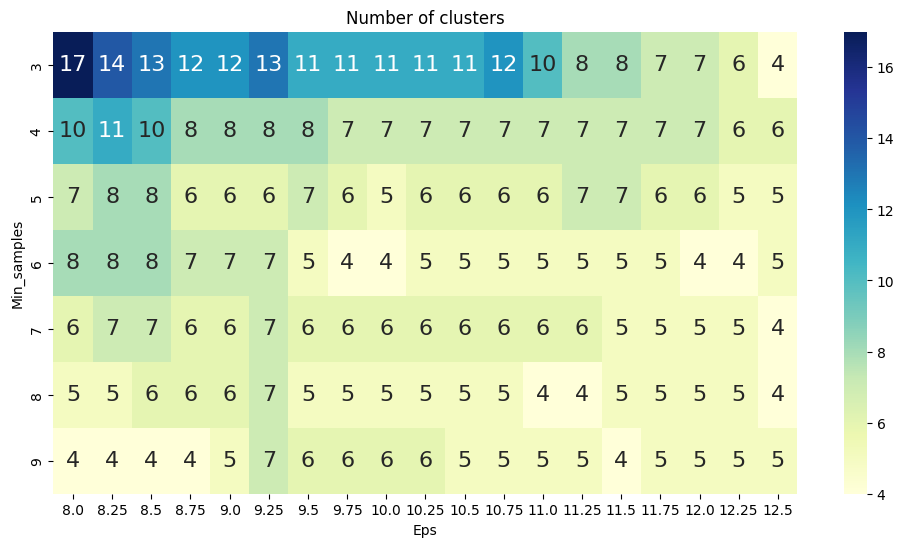

In [114]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

>**Eps와 Min_sample 의 조합에 따른 실루엣 점수**

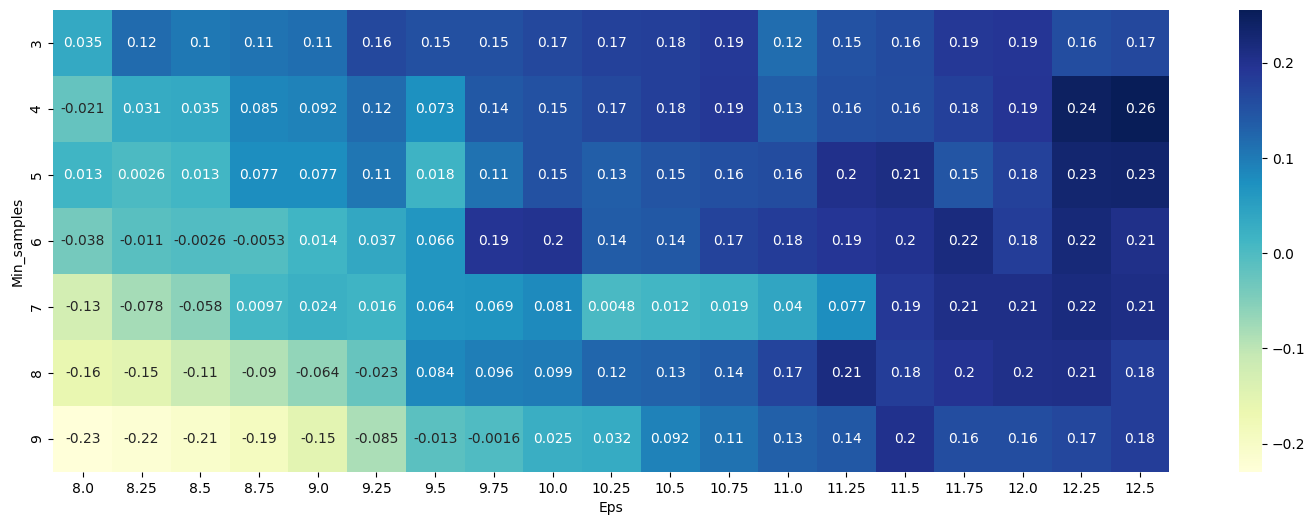

In [115]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [103]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_

In [104]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


>**DBSCAN 클러스터링 결과 시각화**

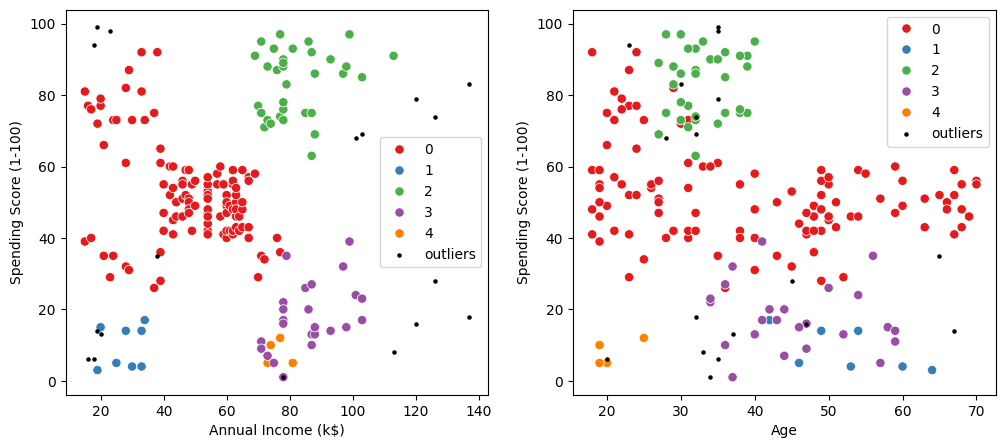

In [105]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',  #x에는 Annual Income y에는 Spending Score
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)


sns.scatterplot(x='Age', y='Spending Score (1-100)',  #x에는 Age y에는 Spending Score
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)


axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

In [62]:
from sklearn.cluster import KMeans

In [63]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

In [84]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

In [85]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,77
1,39
2,25
3,23
4,36


>**K-Means 시각화**

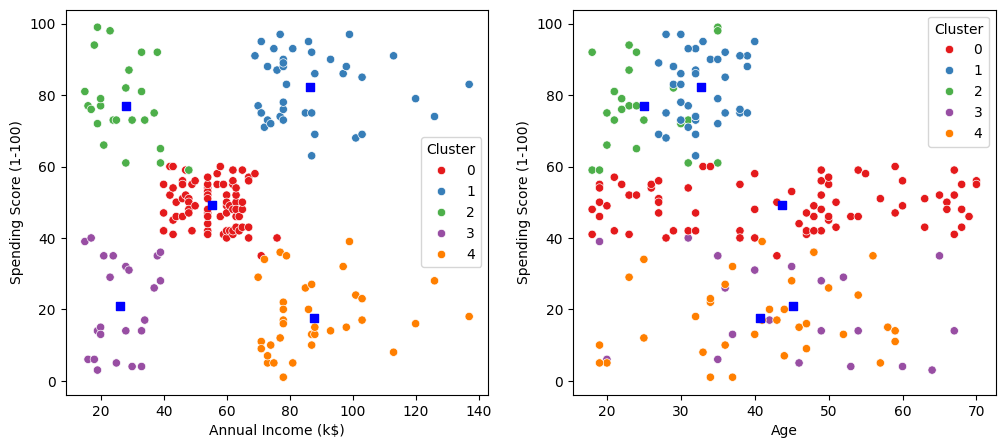

In [86]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

In [87]:
from sklearn.cluster import AffinityPropagation

In [88]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [89]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [90]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


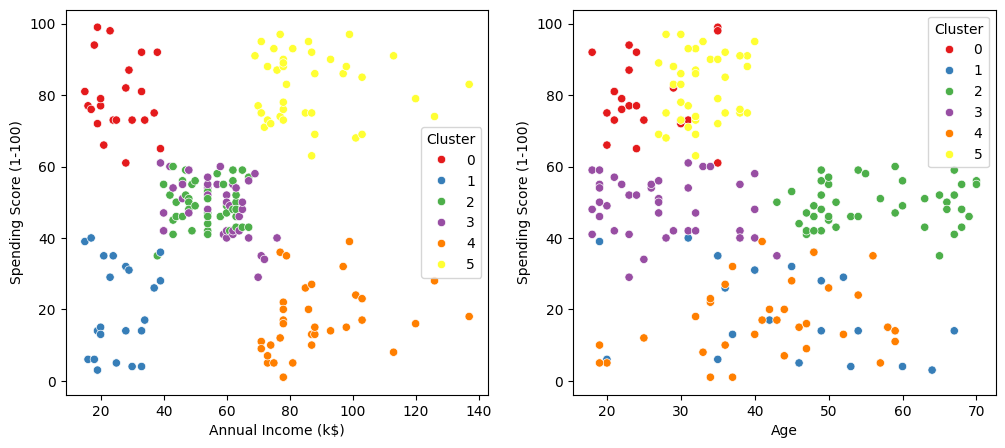

In [91]:
fig3, ax_af = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

K-Means Silhouette Score: 0.4405
DBSCAN Silhouette Score: 0.2556
Affinity Propagation Silhouette Score: 0.4516


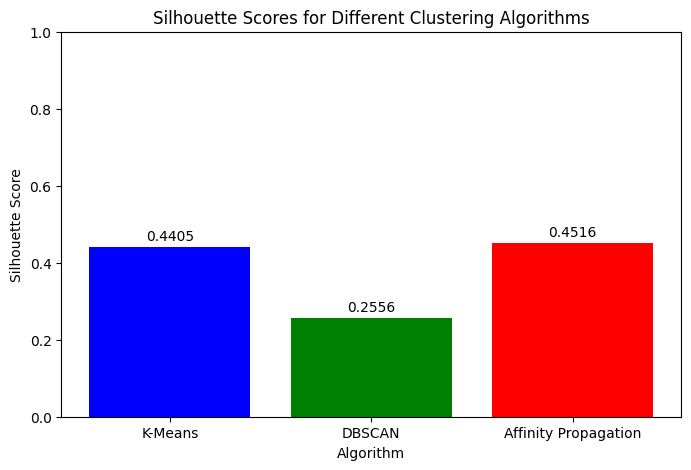

In [92]:
# K-Means
kmeans_labels = KM5_clustered['Cluster'].values

# DBSCAN
dbscan_labels = DBSCAN_clustered['Cluster'].values

# Affinity Propagation
ap_labels = AF_clustered['Cluster'].values

# Step 2: Silhouette Score 계산
# K-Means Silhouette Score
sil_kmeans = silhouette_score(X_numerics, kmeans_labels)

# DBSCAN Silhouette Score
sil_dbscan = silhouette_score(X_numerics, dbscan_labels)

# Affinity Propagation Silhouette Score
sil_ap = silhouette_score(X_numerics, ap_labels)

# Step 3: 결과 출력
print(f"K-Means Silhouette Score: {sil_kmeans:.4f}")
print(f"DBSCAN Silhouette Score: {sil_dbscan:.4f}")
print(f"Affinity Propagation Silhouette Score: {sil_ap:.4f}")

# Step 4: 결과 시각화
scores = [sil_kmeans, sil_dbscan, sil_ap]
algorithms = ['K-Means', 'DBSCAN', 'Affinity Propagation']

plt.figure(figsize=(8, 5))
bars = plt.bar(algorithms, scores, color=['blue', 'green', 'red'])  # 막대 객체 저장
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.ylabel('Silhouette Score')
plt.xlabel('Algorithm')
plt.ylim(0, 1)  # 실루엣 스코어는 -1에서 1 사이 값

# 그래프 위에 스코어 점수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,  # 막대 위 약간 위에 텍스트 위치
        f'{yval:.4f}',  # 소수점 4자리까지 표시
        ha='center',  # 수평 정렬: 중앙
        va='bottom'   # 수직 정렬: 아래
    )

plt.show()


In [29]:
!git clone https://github.com/colinwke/dpca.git

Cloning into 'dpca'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47 (from 1)
Receiving objects: 100% (47/47), 419.11 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [30]:
%cd dpca


/content/dpca


In [31]:
import sys
sys.path.append('/content/dpca')  # '/content/dpca'는 저장소 클론 경로


Silhouette Score: 0.3488


<ipython-input-107-a8b5327731f4>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerics['Cluster'] = custom_labels


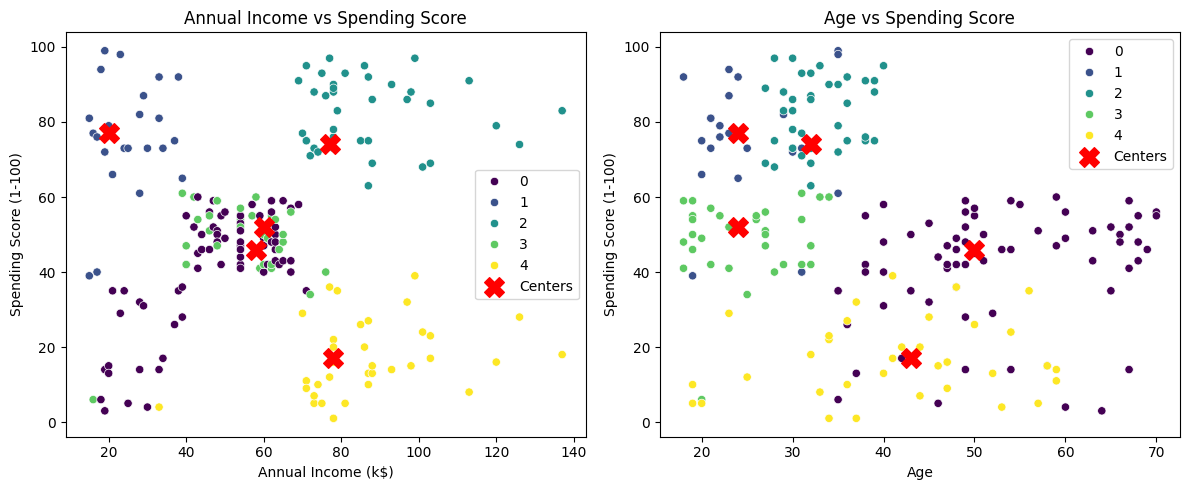

In [107]:
from dpca import DensityPeakCluster
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. 데이터 준비
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only
X_array = X_numerics.values

# 2. 적절한 dc 값 자동 계산
distances = pairwise_distances(X_array)
dc_auto = np.percentile(distances, 2)  # 2% 백분위수

# 3. Density Peak Clustering 모델 생성 및 학습
dpca_model = DensityPeakCluster(
    dc=dc_auto,  # 자동 계산한 dc 값
    distance_metric="euclidean",
    silence=True,
    gauss_cutoff=False,
    anormal=False
)

# 클러스터링 수행
dpca_model.fit(X_array)

# 4. 클러스터 레이블 가져오기
dpc_labels = dpca_model.labels_

# 5. Silhouette Score 계산
if len(set(dpc_labels)) > 1:  # 클러스터가 2개 이상인 경우에만 계산 가능
    sil_score = silhouette_score(X_array, dpc_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
else:
    sil_score = None
    print("Silhouette Score cannot be calculated: Only one cluster found.")

# 6. 밀도 및 중심점 계산
# 각 포인트의 밀도는 dc 값을 기준으로 주변 포인트의 개수를 통해 계산
density = np.sum(np.exp(-((distances / dc_auto) ** 2)), axis=1)
delta = np.zeros_like(density)

# delta 계산: 더 높은 밀도 값을 가진 가장 가까운 포인트와의 거리
for i in range(len(X_array)):
    higher_density_indices = np.where(density > density[i])[0]
    if len(higher_density_indices) > 0:
        delta[i] = np.min(distances[i, higher_density_indices])
    else:
        delta[i] = np.max(distances[i, :])

# 중심점 계산을 위한 gamma 값 (density * delta)
gamma = density * delta

# 중심점 선택
n_centers = 5 # 원하는 중심점 개수
center_indices = np.argsort(-gamma)[:n_centers]  # gamma 기준으로 상위 N개의 중심점 선택

# 중심점 레이블 재할당
custom_labels = np.full(len(X_array), -1)
for i, center_idx in enumerate(center_indices):
    custom_labels[center_idx] = i

# 각 데이터 포인트를 가장 가까운 중심점으로 할당
for i in range(len(X_array)):
    if custom_labels[i] == -1:
        distances_to_centers = pairwise_distances(X_array[i].reshape(1, -1), X_array[center_indices])
        custom_labels[i] = np.argmin(distances_to_centers)

# 7. 시각화를 위한 데이터 준비
X_numerics['Cluster'] = custom_labels
center_points = X_numerics.iloc[center_indices]

# 8. 시각화
fig1, axes = plt.subplots(1, 2, figsize=(12, 5))

# 첫 번째 그래프: Annual Income vs Spending Score
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=X_numerics,
    hue='Cluster',
    ax=axes[0],
    palette='viridis',
    legend='full'
)
axes[0].scatter(
    center_points['Annual Income (k$)'],
    center_points['Spending Score (1-100)'],
    marker='X',
    s=200,
    c="red",
    label="Centers"
)
axes[0].set_title("Annual Income vs Spending Score")
axes[0].legend()

# 두 번째 그래프: Age vs Spending Score
sns.scatterplot(
    x='Age',
    y='Spending Score (1-100)',
    data=X_numerics,
    hue='Cluster',
    ax=axes[1],
    palette='viridis',
    legend='full'
)
axes[1].scatter(
    center_points['Age'],
    center_points['Spending Score (1-100)'],
    marker='X',
    s=200,
    c="red",
    label="Centers"
)
axes[1].set_title("Age vs Spending Score")
axes[1].legend()

plt.tight_layout()
plt.show()


K-Means Silhouette Score: 0.4404
DBSCAN Silhouette Score: 0.2554
DPC Silhouette Score: 0.3802
Affinity Propagation Silhouette Score: 0.4522


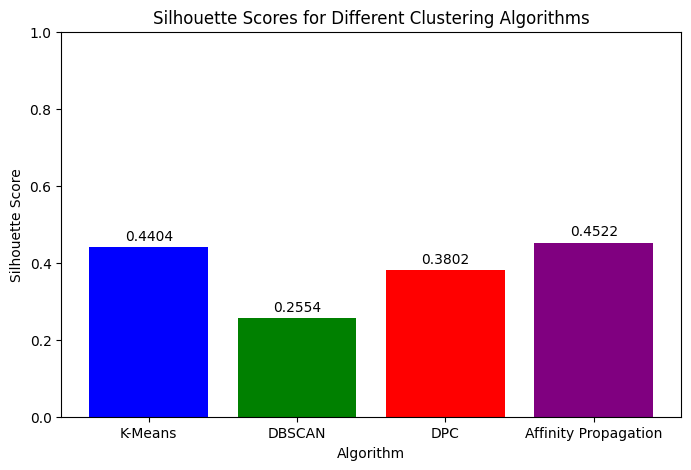

In [108]:
# DPC 클러스터링 레이블 가져오기
dpc_labels = X_numerics['Cluster'].values  # DPC 클러스터링 레이블이 데이터프레임에 이미 저장된 경우

# Step 2: Silhouette Score 계산
# K-Means Silhouette Score
sil_kmeans = silhouette_score(X_numerics, kmeans_labels)

# DBSCAN Silhouette Score
sil_dbscan = silhouette_score(X_numerics, dbscan_labels)

# Affinity Propagation Silhouette Score
sil_ap = silhouette_score(X_numerics, ap_labels)

# DPC Silhouette Score
sil_dpc = silhouette_score(X_numerics, dpc_labels)

# Step 3: 결과 출력
print(f"K-Means Silhouette Score: {sil_kmeans:.4f}")
print(f"DBSCAN Silhouette Score: {sil_dbscan:.4f}")
print(f"DPC Silhouette Score: {sil_dpc:.4f}")
print(f"Affinity Propagation Silhouette Score: {sil_ap:.4f}")

# Step 4: 결과 시각화
scores = [sil_kmeans, sil_dbscan, sil_dpc, sil_ap ]
algorithms = ['K-Means', 'DBSCAN','DPC', 'Affinity Propagation']

plt.figure(figsize=(8, 5))
bars = plt.bar(algorithms, scores, color=['blue', 'green', 'red', 'purple'])  # DPC를 위한 추가 색상
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.ylabel('Silhouette Score')
plt.xlabel('Algorithm')
plt.ylim(0, 1)  # 실루엣 스코어는 -1에서 1 사이 값

# 그래프 위에 스코어 점수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,  # 막대 위 약간 위에 텍스트 위치
        f'{yval:.4f}',  # 소수점 4자리까지 표시
        ha='center',  # 수평 정렬: 중앙
        va='bottom'   # 수직 정렬: 아래
    )

plt.show()
